# Weather Py

**Observation 1:** Temperatures seem to be highest in the lower latitudes (closer to the equator), but the highest temperatures were recorded at cities between 15 and 35 degrees North.<br>
**Observation 2:** We are unable to record weather at all extreme latitudes where cities are not located. We have the most data in latitudes where there are commonly cities found, between -30 degrees South and 60 degrees North latitude. Another way to go about this would have been to generate random latitudes and longitudes and look directly with those coordinates in the openweathermap API, which would have allowed us to cover more of the earth's surface.<br>
**Observation 3:** Other weather elements are extremely variable, but it stands out that humidity is almost never 0, dips lowest around 20 degrees South latitude, and between 20 and 40 degrees North latitude, and it appears that it is more common for cities close to the equator to have 100% humidity than for those further away 

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
import pandas as pd
import numpy as np
import requests
import time as t
from datetime import datetime
from pprint import pprint
import os

# Import API key
from api_keys import api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"
directory = os.path.dirname(output_data_file)
if not os.path.exists(directory):
    os.makedirs(directory)
    
# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(low=-90.000, high=90.000, size=1500)
lngs = np.random.uniform(low=-180.000, high=180.000, size=1500)
lat_lngs = zip(lats, lngs)
city_lats = []
city_lngs = []
country = []

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1])
    country_code=city.country_code
    city = city.city_name
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)
        country.append(country_code)

# Print the city count to confirm sufficient count
city_data = pd.DataFrame({"City":cities, "Country":country})
print(len(city_data))
city_data.head()

650


,City,Country
0,sosnovo-ozerskoye,ru
1,atuona,pf
2,hermanus,za
3,aksarka,ru
4,koppang,no


In [3]:
#Build out the dataframe in city_data with new columns
city_data["Lat"] = ""
city_data["Lng"] = ""
city_data["Humidity"] = ""
city_data["Max Temp"] = ""
city_data["Wind Speed"] = ""
city_data["Clouds"] = ""
city_data["Date"] = ""
city_data.head()

,City,Country,Lat,Lng,Humidity,Max Temp,Wind Speed,Clouds,Date
0,sosnovo-ozerskoye,ru,,,,,,,
1,atuona,pf,,,,,,,
2,hermanus,za,,,,,,,
3,aksarka,ru,,,,,,,
4,koppang,no,,,,,,,


In [4]:
# Make the calls to OpenWeatherMap with correct processing
clength = len(city_data)
runs = clength // 50
extra = clength % 50
counter_a = 1
failed = 0

#Run for all the sets where 50 recrods will be pulled
for x in range(runs):
    counter_b = 1
    for y in range(50):
        z = x*50 + y
        search_city = city_data["City"][z]
        search_city = search_city.replace(" ", "%20")
        url = f'http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID={api_key}&q={search_city},{city_data["Country"][z]}'
        city_full = requests.get(url).json()
        print(f'Processing Record {counter_b} of Set {counter_a} | {city_data["City"][z]}, {city_data["Country"][z]}')
        print(f'URL: {url}')
        try:
            city_data["Lat"][z] = city_full["coord"]["lat"]
            city_data["Lng"][z] = city_full["coord"]["lon"]
            city_data["Humidity"][z] = city_full["main"]["humidity"]
            city_data["Max Temp"][z] = city_full["main"]["temp_max"]
            city_data["Wind Speed"][z] = city_full["wind"]["speed"]
            city_data["Clouds"][z] = city_full["clouds"]["all"]
            time = datetime.now()
            date = datetime.strftime(time, '%m-%d-%Y')
            city_data["Date"][z] = date
        except KeyError:
            print(f'Open Weather Map cannot find {city_data["City"][z]},{city_data["Country"][z]}')
            failed += 1
        print('------------------')
        
        counter_b += 1
    counter_a += 1
    t.sleep(30)

#Run for the last set, with less than 50 records
x = runs
counter_b = 1
for i in range(extra):
    z = i + runs*50 
    search_city = city_data["City"][z]
    search_city = search_city.replace(" ", "%20")
    url = f'http://api.openweathermap.org/data/2.5/weather?units=Metric&APPID={api_key}&q={search_city},{city_data["Country"][z]}'
    city_full = requests.get(url).json()
    print(f'Processing Record {counter_b} of Set {counter_a} | {city_data["City"][z]}, {city_data["Country"][z]}')
    print(f'URL: {url}')
    try:
        city_data["Lat"][z] = city_full["coord"]["lat"]
        city_data["Lng"][z] = city_full["coord"]["lon"]
        city_data["Humidity"][z] = city_full["main"]["humidity"]
        city_data["Max Temp"][z] = city_full["main"]["temp_max"]
        city_data["Wind Speed"][z] = city_full["wind"]["speed"]
        city_data["Clouds"][z] = city_full["clouds"]["all"]
        time = datetime.now()
        date = datetime.strftime(time, '%m-%d-%Y')
        city_data["Date"][z] = date
    except KeyError:
        print(f'Open Weather Map cannot find {city_data["City"][z]},{city_data["Country"][z]}')
        failed += 1
    print('------------------')
    
    counter_b += 1
    
print(f'Failed: {failed}')
print(f'Records Remaining: {clength-failed}')
print("-----------------------")
print("Data Retrieval Complete")
print("-----------------------")

Processing Record 1 of Set 1 | sosnovo-ozerskoye, ru
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=sosnovo-ozerskoye,ru
------------------
Processing Record 2 of Set 1 | atuona, pf
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=atuona,pf
------------------
Processing Record 3 of Set 1 | hermanus, za
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=hermanus,za
------------------
Processing Record 4 of Set 1 | aksarka, ru
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=aksarka,ru
------------------
Processing Record 5 of Set 1 | koppang, no
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=koppang,no
------------------
Processing Record 6 of Set 1 | nakatsugawa, jp
URL: http://api.openweatherm

Processing Record 46 of Set 1 | khatanga, ru
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=khatanga,ru
------------------
Processing Record 47 of Set 1 | amderma, ru
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=amderma,ru
Open Weather Map cannot find amderma,ru
------------------
Processing Record 48 of Set 1 | fuyang, cn
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=fuyang,cn
------------------
Processing Record 49 of Set 1 | vaini, to
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=vaini,to
------------------
Processing Record 50 of Set 1 | arraial do cabo, br
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=arraial%20do%20cabo,br
------------------
Processing Record 1 of Set 2 | bar

Processing Record 40 of Set 2 | kendari, id
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=kendari,id
------------------
Processing Record 41 of Set 2 | ilulissat, gl
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=ilulissat,gl
------------------
Processing Record 42 of Set 2 | attawapiskat, ca
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=attawapiskat,ca
Open Weather Map cannot find attawapiskat,ca
------------------
Processing Record 43 of Set 2 | fortuna, us
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=fortuna,us
------------------
Processing Record 44 of Set 2 | borovoy, ru
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=borovoy,ru
------------------
Processing Record 45 of Set 2 |

Processing Record 33 of Set 3 | karratha, au
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=karratha,au
------------------
Processing Record 34 of Set 3 | la rioja, ar
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=la%20rioja,ar
------------------
Processing Record 35 of Set 3 | dekoa, cf
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=dekoa,cf
Open Weather Map cannot find dekoa,cf
------------------
Processing Record 36 of Set 3 | camabatela, ao
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=camabatela,ao
------------------
Processing Record 37 of Set 3 | kichera, ru
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=kichera,ru
------------------
Processing Record 38 of Set 3 | tazmalt, dz


Processing Record 27 of Set 4 | umm lajj, sa
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=umm%20lajj,sa
------------------
Processing Record 28 of Set 4 | galle, lk
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=galle,lk
------------------
Processing Record 29 of Set 4 | mumford, gh
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=mumford,gh
------------------
Processing Record 30 of Set 4 | bambous virieux, mu
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=bambous%20virieux,mu
------------------
Processing Record 31 of Set 4 | batemans bay, au
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=batemans%20bay,au
------------------
Processing Record 32 of Set 4 | kaitangata, nz
URL: http://a

Processing Record 20 of Set 5 | lusambo, cd
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=lusambo,cd
------------------
Processing Record 21 of Set 5 | mys shmidta, ru
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=mys%20shmidta,ru
Open Weather Map cannot find mys shmidta,ru
------------------
Processing Record 22 of Set 5 | bengkulu, id
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=bengkulu,id
Open Weather Map cannot find bengkulu,id
------------------
Processing Record 23 of Set 5 | laguna, br
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=laguna,br
Open Weather Map cannot find laguna,br
------------------
Processing Record 24 of Set 5 | arrecife, es
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6

Processing Record 13 of Set 6 | pleasanton, us
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=pleasanton,us
------------------
Processing Record 14 of Set 6 | husavik, is
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=husavik,is
------------------
Processing Record 15 of Set 6 | sobolevo, ru
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=sobolevo,ru
------------------
Processing Record 16 of Set 6 | kahului, us
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=kahului,us
------------------
Processing Record 17 of Set 6 | ribeira grande, pt
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=ribeira%20grande,pt
------------------
Processing Record 18 of Set 6 | mayo, ca
URL: http://api.openweath

Processing Record 7 of Set 7 | nikolskoye, ru
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=nikolskoye,ru
------------------
Processing Record 8 of Set 7 | miranda de ebro, es
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=miranda%20de%20ebro,es
------------------
Processing Record 9 of Set 7 | sorong, id
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=sorong,id
------------------
Processing Record 10 of Set 7 | alofi, nu
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=alofi,nu
------------------
Processing Record 11 of Set 7 | planaltina, br
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=planaltina,br
------------------
Processing Record 12 of Set 7 | miri, my
URL: http://api.openweathe

Processing Record 1 of Set 8 | udachnyy, ru
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=udachnyy,ru
------------------
Processing Record 2 of Set 8 | saint-leu, re
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=saint-leu,re
------------------
Processing Record 3 of Set 8 | matagami, ca
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=matagami,ca
------------------
Processing Record 4 of Set 8 | filadelfia, py
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=filadelfia,py
------------------
Processing Record 5 of Set 8 | te anau, nz
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=te%20anau,nz
------------------
Processing Record 6 of Set 8 | mosquera, co
URL: http://api.openweathermap.org/

Processing Record 46 of Set 8 | kasane, bw
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=kasane,bw
------------------
Processing Record 47 of Set 8 | touros, br
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=touros,br
------------------
Processing Record 48 of Set 8 | mahanje, tz
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=mahanje,tz
Open Weather Map cannot find mahanje,tz
------------------
Processing Record 49 of Set 8 | dillon, us
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=dillon,us
------------------
Processing Record 50 of Set 8 | bundaberg, au
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=bundaberg,au
------------------
Processing Record 1 of Set 9 | alice springs, au
URL

Processing Record 40 of Set 9 | ngaoundere, cm
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=ngaoundere,cm
------------------
Processing Record 41 of Set 9 | zhuhai, cn
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=zhuhai,cn
------------------
Processing Record 42 of Set 9 | vredendal, za
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=vredendal,za
------------------
Processing Record 43 of Set 9 | veseloyarsk, ru
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=veseloyarsk,ru
------------------
Processing Record 44 of Set 9 | kempsey, au
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=kempsey,au
------------------
Processing Record 45 of Set 9 | kimbe, pg
URL: http://api.openweathermap.o

Processing Record 35 of Set 10 | toumodi, ci
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=toumodi,ci
------------------
Processing Record 36 of Set 10 | okhotsk, ru
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=okhotsk,ru
------------------
Processing Record 37 of Set 10 | faanui, pf
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=faanui,pf
------------------
Processing Record 38 of Set 10 | majene, id
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=majene,id
------------------
Processing Record 39 of Set 10 | baturaja, id
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=baturaja,id
------------------
Processing Record 40 of Set 10 | san cristobal, ec
URL: http://api.openweathermap.org/d

Processing Record 29 of Set 11 | yuzhne, ua
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=yuzhne,ua
------------------
Processing Record 30 of Set 11 | kuryk, kz
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=kuryk,kz
------------------
Processing Record 31 of Set 11 | svetlogorsk, ru
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=svetlogorsk,ru
------------------
Processing Record 32 of Set 11 | erdenet, mn
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=erdenet,mn
------------------
Processing Record 33 of Set 11 | yumen, cn
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=yumen,cn
------------------
Processing Record 34 of Set 11 | gobabis, na
URL: http://api.openweathermap.org/data/2.

Processing Record 23 of Set 12 | srednekolymsk, ru
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=srednekolymsk,ru
------------------
Processing Record 24 of Set 12 | san isidro, ph
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=san%20isidro,ph
------------------
Processing Record 25 of Set 12 | pedernales, ec
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=pedernales,ec
------------------
Processing Record 26 of Set 12 | longlac, ca
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=longlac,ca
Open Weather Map cannot find longlac,ca
------------------
Processing Record 27 of Set 12 | zhezkazgan, kz
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=zhezkazgan,kz
------------------
Processing Re

Processing Record 18 of Set 13 | ordubad, az
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=ordubad,az
------------------
Processing Record 19 of Set 13 | voznesenye, ru
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=voznesenye,ru
------------------
Processing Record 20 of Set 13 | balkhash, kz
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=balkhash,kz
------------------
Processing Record 21 of Set 13 | ballina, au
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=ballina,au
------------------
Processing Record 22 of Set 13 | sentyabrskiy, ru
URL: http://api.openweathermap.org/data/2.5/weather?units=Imperial&APPID=67947cb38f9979cc68c6f002608b158a&q=sentyabrskiy,ru
Open Weather Map cannot find sentyabrskiy,ru
------------------
Processing Record 23 o

In [5]:
city_data_ref = city_data[city_data["Lat"] !=""]
city_data_ref.reset_index(drop=True, inplace=True)
city_data_ref = city_data_ref[["City", "Clouds","Country", "Date", "Humidity", "Lat", "Lng", "Max Temp", "Wind Speed"]]
city_data_ref.count()

City          566
Clouds        566
Country       566
Date          566
Humidity      566
Lat           566
Lng           566
Max Temp      566
Wind Speed    566
dtype: int64

In [6]:
city_data_ref.to_csv(output_data_file, index=False)
city_data_ref.head()

,City,Clouds,Country,Date,Humidity,Lat,Lng,Max Temp,Wind Speed
0,sosnovo-ozerskoye,92,ru,07-07-2018,100,52.53,111.54,51.73,10.67
1,atuona,64,pf,07-07-2018,100,-9.8,-139.03,79.18,17.49
2,hermanus,0,za,07-07-2018,77,-34.42,19.24,37.69,2.51
3,aksarka,92,ru,07-07-2018,81,66.56,67.8,59.47,11.45
4,koppang,8,no,07-07-2018,86,61.57,11.04,42.82,2.17


In [7]:
med_inx = len(city_data_ref)//2
graph_date = city_data_ref.iloc[med_inx-1, 3]
graph_date

'07-07-2018'

## Latitude vs Temperature Plot

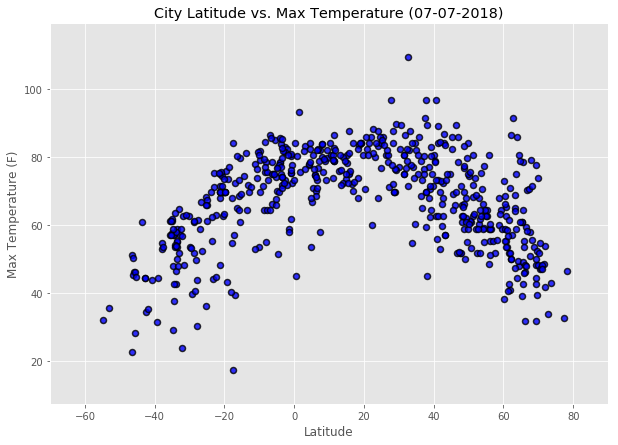

In [9]:
x_vals = city_data_ref["Lat"]
y_vals = city_data_ref["Max Temp"]

plt.figure(figsize=(10,7))
plt.scatter(x_vals, y_vals, marker="o", facecolors="blue", edgecolors="black", linewidth=1.5, alpha=0.8)

# Incorporate the other graph properties
plt.title(f"City Latitude vs. Max Temperature ({graph_date})")
plt.ylabel("Max Temperature (F)")
plt.xlim(-70,90)
plt.ylim(y_vals.min()-10,y_vals.max()+10)
plt.xlabel("Latitude")
plt.savefig("output_data/Lat_Temp.png")
plt.show()

## Latitude vs. Humidity Plot

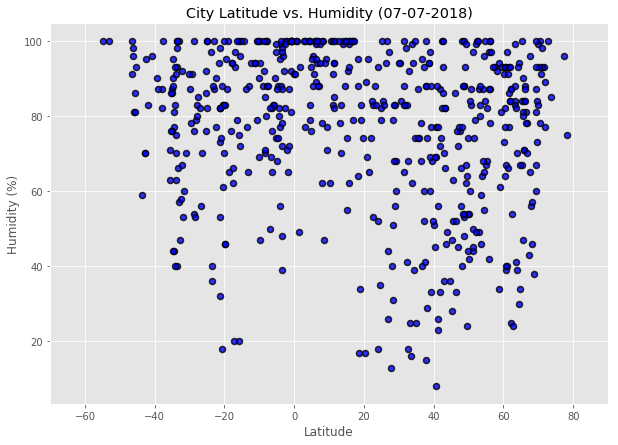

In [10]:
x_vals = city_data_ref["Lat"]
y_vals = city_data_ref["Humidity"]

plt.figure(figsize=(10,7))
plt.scatter(x_vals, y_vals, marker="o", facecolors="blue", edgecolors="black", linewidth=1.5, alpha=0.8)

# Incorporate the other graph properties
plt.title(f"City Latitude vs. Humidity ({graph_date})")
plt.ylabel("Humidity (%)")
plt.xlim(-70,90)
#plt.ylim(-20,60)
plt.xlabel("Latitude")
plt.savefig("output_data/Lat_Humidity.png")
plt.show()

## Latitude vs. Cloudiness Plot

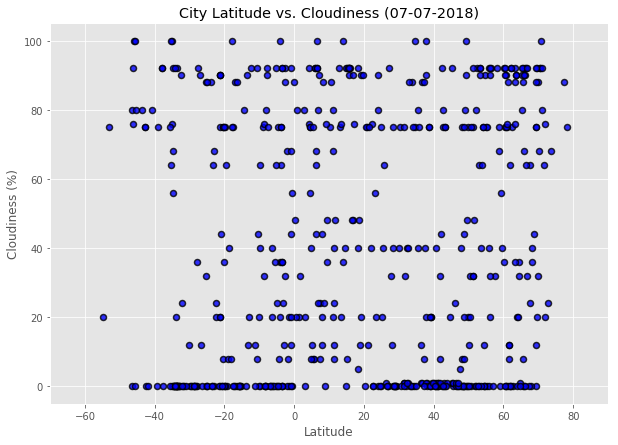

In [11]:
x_vals = city_data_ref["Lat"]
y_vals = city_data_ref["Clouds"]

plt.figure(figsize=(10,7))
plt.scatter(x_vals, y_vals, marker="o", facecolors="blue", edgecolors="black", linewidth=1.5, alpha=0.8)

# # Incorporate the other graph properties
plt.title(f"City Latitude vs. Cloudiness ({graph_date})")
plt.ylabel("Cloudiness (%)")
plt.xlim(-70,90)
#plt.ylim(-20,60)
plt.xlabel("Latitude")
plt.savefig("output_data/Lat_Clouds.png")
plt.show()

## Latitude vs. Wind Speed Plot

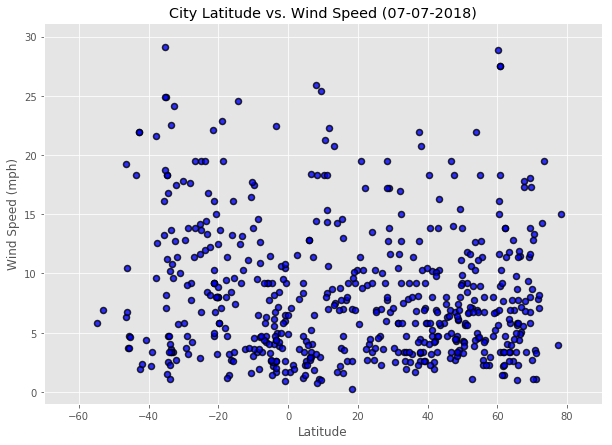

In [12]:
x_vals = city_data_ref["Lat"]
y_vals = city_data_ref["Wind Speed"]

plt.figure(figsize=(10,7))
plt.scatter(x_vals, y_vals, marker="o", facecolors="blue", edgecolors="black", linewidth=1.5, alpha=0.8)

# # Incorporate the other graph properties
plt.title(f"City Latitude vs. Wind Speed ({graph_date})")
plt.ylabel("Wind Speed (mph)")
plt.xlim(-70,90)
plt.ylim(-1,y_vals.max()+2)
plt.xlabel("Latitude")
plt.savefig("output_data/Lat_WindSpeed.png")
plt.show()

In [15]:
# You can bin latitudes to see how many cities we have in each. (This is just an extra check)
### this shows something important, we have no cities between -90 and -60 degrees South Latitude.
bins = [-90,-60,-30,0,30,60,90]
bin_names = ["90-60 S", "60-30 S", "30-0 S", "0-30 N", "30-60 N", "60-90 N"]
john = pd.cut(city_data_ref["Lat"], bins, labels=bin_names)
city_data_ref["lat_bin"] = john
Lat_counts = city_data_ref.groupby("lat_bin")["City"].count()
Lat_counts

lat_bin
90-60 S      0
60-30 S     58
30-0 S     144
0-30 N     117
30-60 N    162
60-90 N     85
Name: City, dtype: int64